In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random
import time

In [2]:
# set seed, so we can get the same results after rerunning several times
np.random.seed(1234)
tf.random.set_seed(1234)
random.seed(1234)

In [33]:
N_STEPS = 50

LOOKUP_STEP = 1

SCALE = True
scale_str = f"scale-{int(SCALE)}"

SHUFFLE = True
shuffle_str = f"shuffle-{int(SHUFFLE)}"

SPLIT_BY_DATE = False
split_by_date_str = f"split_date-{int(SPLIT_BY_DATE)}"

TEST_SIZE = 0.2

FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

date_now = time.strftime("%Y-%m-%d")

# model parameters

N_LAYERS = 3
CELL = LSTM
UNITS = 256
DROPOUT = 0.8
BIDIRECTIONAL = False

# training parameters

LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 32
EPOCHS = 10
epochs = f"epochs-{int(EPOCHS)}"

# Choose Ticker
ticker = "AMC"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-{epochs}"

* ticker (str/pd.DataFrame)
* n_steps (int) - default = 50
* scale (bool) - default = True
* shuffle (bool) - default = True
* lookup_step (int) - default = 1 (e.g next day)
* split_by_date (bool)
* test_size (float) - default = 0.2 
* feature_columns (list)

In [4]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

In [5]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")

    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()

    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index

    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler

    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)

    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    
    # drop NaNs
    df.dropna(inplace=True)

    sequence_data = []
    sequences = deque(maxlen=n_steps)

    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])

    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    result['last_sequence'] = last_sequence
    
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # split dataset by date 
    if split_by_date:
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)

    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)

    return result

In [6]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [7]:
import matplotlib.pyplot as plt

def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [8]:
def get_final_df(model, data):
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    
    return final_df

In [9]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [34]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

# save the dataframe
data["df"].to_csv(ticker_data_filename)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [35]:
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/10
48/48 [==============================] - 39s 701ms/step - loss: 0.0054 - mean_absolute_error: 0.0691 - val_loss: 9.7461e-04 - val_mean_absolute_error: 0.0279

Epoch 00001: val_loss improved from inf to 0.00097, saving model to results\2021-09-09_AMC-shuffle-1-scale-1-split_date-0-epochs-10.h5
Epoch 2/10
48/48 [==============================] - 19s 403ms/step - loss: 0.0033 - mean_absolute_error: 0.0565 - val_loss: 7.1081e-04 - val_mean_absolute_error: 0.0197

Epoch 00002: val_loss improved from 0.00097 to 0.00071, saving model to results\2021-09-09_AMC-shuffle-1-scale-1-split_date-0-epochs-10.h5
Epoch 3/10
48/48 [==============================] - 17s 365ms/step - loss: 0.0023 - mean_absolute_error: 0.0443 - val_loss: 7.3012e-04 - val_mean_absolute_error: 0.0267

Epoch 00003: val_loss did not improve from 0.00071
Epoch 4/10
48/48 [==============================] - 19s 408ms/step - loss: 0.0020 - mean_absolute_error: 0.0424 - val_loss: 4.6180e-04 - val_mean_absolute_error: 0.0

In [36]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")

if not os.path.isdir("logs"):
    os.mkdir("logs")

if not os.path.isdir("data"):
    os.mkdir("data")

# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [37]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [38]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [39]:
# predict the future price
future_price = predict(model, data)

In [40]:
# we calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [41]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)

Future price after 1 days is 43.99$
huber_loss loss: 0.00037134677404537797
Mean Absolute Error: 2.8584244541194566
Accuracy score: 0.46965699208443273


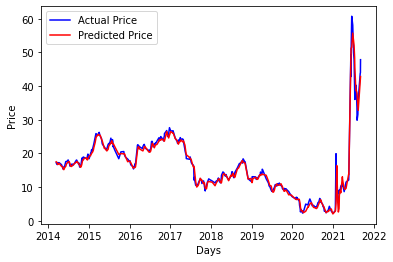

In [42]:
# plot true/pred prices graph
plot_graph(final_df)

In [43]:
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)

In [44]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

trace1 = go.Scatter(
    y=history.history['loss'],
    name = "Training Loss",
    marker=dict(color='rgba(171, 50, 96, 0.6)'))
trace2 = go.Scatter(
    y=history.history['val_loss'],
    name = "Validation Loss",
    marker=dict(color='rgba(12, 50, 196, 0.6)'))

data = [trace1, trace2]
layout = go.Layout(title='Loss and Val_Loss in 500 Epochs',
                   xaxis=dict(title='Epoch'),
                   yaxis=dict(title='Loss'),
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, config={'showLink': True})

In [30]:
%load_ext tensorboard
%tensorboard --logdir="logs"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31368), started 1 day, 10:56:50 ago. (Use '!kill 31368' to kill it.)